# MNIST VAE with enumeration of discrete latent variable

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as tvt
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO #, TraceGraph_ELBO
from pyro.optim import Adam, Adamax, Adadelta, SGD
from torchvision import utils
from matplotlib.pyplot import imshow
from torch.distributions import constraints

### Helper function

In [2]:
def show_batch(images,nrow=4,npadding=10):
    """Visualize a torch tensor of shape: (batch x ch x width x height) """
    batch, ch, width, height = images.shape
    if(images.device != "cpu"):
        images=images.cpu()
    grid = utils.make_grid(images,nrow, npadding, normalize=True, range=None, scale_each=True, pad_value=1)       
    imshow(grid.detach().numpy().transpose((1, 2, 0))) 
    
def train_one_epoch(svi, dataloader, verbose=False):
    epoch_loss = 0.
    n = 0
    for i, data in enumerate(dataloader, 0): #loop over minibatches
            
        # Get images and flatten them into vectors
        imgs,labels= data
        n += len(labels)
        loss = svi.step(imgs)
        
        if(verbose):
            print("i= %3d train_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / n

def evaluate_one_epoch(svi, dataloader, verbose=False):
    epoch_loss = 0.
    n = 0
    for i, data in enumerate(dataloader, 0): #loop over minibatches
            
        # Get images and flatten them into vectors
        imgs,labels= data
        n += len(labels)
        loss = svi.evaluate_loss(imgs)
        
        if(verbose):
            print("i= %3d  test_loss=%.5f" %(i,loss))
        epoch_loss += loss

    return epoch_loss / n

def save_obj(obj,root_dir,name):
    with open(root_dir + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(root_dir,name):
    with open(root_dir + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def save_model(model, root_dir, name):
    full_file_path= root_dir + name + '.pkl'
    torch.save(model.state_dict(),full_file_path)
    
def load_model(model, root_dir, name):
    full_file_path= root_dir + name + '.pkl'
    model.load_state_dict(torch.load(full_file_path))

### Define the simulation parameters

In [3]:
params = { 
    'K' : 10, #number of clusters
    'CHANNELS' : 1,
    'WIDTH' : 28,
    'HEIGHT':28,
    'Z_DIM':2,
    'use_cuda' : torch.cuda.is_available()
    }
print(params)

{'K': 10, 'CHANNELS': 1, 'WIDTH': 28, 'HEIGHT': 28, 'Z_DIM': 2, 'use_cuda': False}


### Get the data

torch.Size([64, 1, 28, 28])


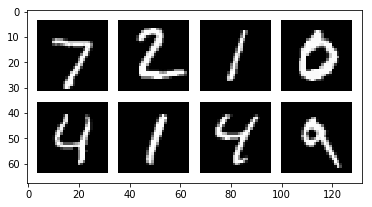

In [4]:
BATCH_SIZE = 64
kwargs = {'num_workers': 1, 'pin_memory': params["use_cuda"]}

trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=tvt.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, **kwargs)
testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=tvt.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, **kwargs)

imgs,labels = next(iter(testloader))

print(imgs.shape)
show_batch(imgs[:8],npadding=4)

### Define the VAE class

In [5]:
class ENCODER(torch.nn.Module):
    """ x -> p """
    
    def __init__(self, params):
        super().__init__()
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        self.comp_p  = torch.nn.Linear(self.x_dim,self.K, bias=True)
        self.softmax = torch.nn.Softmax(dim=-1)

    def forward(self,x):
        batch_size = x.shape[0]
        x1 = x.view(batch_size,-1)
        p = self.softmax(self.comp_p(x1))
        return p
    
class DECODER(torch.nn.Module):
    """ z -> x """
    
    def __init__(self, params):
        super().__init__()
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        self.comp_x_mu  = torch.nn.Linear(self.z_dim,self.x_dim, bias=True)
         
    def forward(self,z):
        batch_size = z.shape[0]
        x_mu = torch.sigmoid(self.comp_x_mu(z)).view(batch_size,self.ch,self.height,self.width)
        return x_mu
        


class VAE(torch.nn.Module):
    
    def __init__(self,params,encoder,decoder):
        super().__init__()
        
        # Parameters
        self.use_cuda = params['use_cuda']
        self.K      = params['K']
        self.ch     = params['CHANNELS']
        self.width  = params['WIDTH']
        self.height = params['HEIGHT']
        self.z_dim  = params['Z_DIM']
        self.x_dim = self.ch*self.width*self.height
        
        # Instantiate the encoder and decoder
        self.decoder = decoder
        self.encoder = encoder
        
        if(self.use_cuda):
            self.cuda()
        
    def guide(self, imgs=None):
        """ 1. run the inference to get: zwhere,zwhat
            2. sample latent variables 
        """       
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#

        batch_size,ch,width,height = imgs.shape
        pyro.module("encoder", self.encoder)

        # Global variables
        locs_mu = pyro.param("locs_mu",imgs.new_zeros(self.K,self.z_dim))
        locs_q = pyro.sample('locs', dist.Delta(locs_mu).to_event(1))
        
        scales_mu = pyro.param("scales_mu",imgs.new_ones(self.K,self.z_dim),constraint=constraints.positive)
        scales_q = pyro.sample('scales', dist.Delta(scales_mu).to_event(1))
        
        concentrations = pyro.param("concentrations",imgs.new_ones(self.K),constraint=constraints.positive)
        weights_q = pyro.sample('weights', dist.Dirichlet(concentrations))
        
        with pyro.plate('batch_size', batch_size, dim=-1):
            p = self.encoder(imgs)
            assignment = pyro.sample('assignment',dist.Categorical(p))
            z = pyro.sample('z_style', dist.Normal(locs_q[assignment], scales_q[assignment]).to_event(1))
        return p,z
            
    def model(self, imgs=None):
        """ 1. sample the latent from the prior:
                - z_type ~ Categorical(weights) 
                - z_style ~ N(loc,scale) 
            2. runs the generative model
            3. score the generative model against actual data 
        """
        #-----------------------#
        #--------  Trick -------#
        #-----------------------#
        if(imgs is None):
            observed = False
            imgs = torch.zeros(8,self.ch,self.height,self.width)
            if(self.use_cuda):
                imgs=imgs.cuda()
        else:
            observed = True
        #-----------------------#
        #----- Enf of Trick ----#
        #-----------------------#
            
        batch_size,ch,width,height = imgs.shape
        pyro.module("decoder", self.decoder)
        
        # Global variable
        weights = pyro.sample('weights', dist.Dirichlet(0.5 * imgs.new_ones(self.K)))

        # Variable for each components
        with pyro.plate('components', self.K, dim=-1):
            locs = pyro.sample('locs', dist.Normal(0., 10.*imgs.new_ones(self.K,self.z_dim)).to_event(1))
            scales = pyro.sample('scales', dist.LogNormal(0., 2.*imgs.new_ones(self.K,self.z_dim)).to_event(1))


        # Variable for each image
        with pyro.plate('batch_size', batch_size, dim=-1):
            assignment = pyro.sample('assignment', dist.Categorical(weights))
            z = pyro.sample('z_style', dist.Normal(locs[assignment], scales[assignment]).to_event(1))
            x_mu = self.decoder(z) #x_mu is between 0 and 1
            pyro.sample('obs', dist.Bernoulli(x_mu.view(-1,self.x_dim)).to_event(1), obs=imgs.view(-1,self.x_dim))
    


In [13]:
encoder = ENCODER(params)
decoder = DECODER(params)
vae = VAE(params,encoder,decoder)
vae.guide()
vae.model()

load_model(vae,"/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/","vae_v5_10")

In [14]:
imgs,labels = next(iter(testloader))

p,z = vae.guide(imgs)

In [15]:
print(labels)
print(p)

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3])
tensor([[0.1074, 0.1003, 0.1025, 0.1236, 0.0977, 0.1023, 0.1028, 0.0917, 0.0835,
         0.0882],
        [0.0833, 0.0993, 0.0934, 0.0949, 0.0809, 0.1552, 0.0972, 0.1040, 0.1048,
         0.0869],
        [0.1117, 0.1130, 0.0855, 0.1154, 0.0909, 0.1170, 0.0910, 0.0954, 0.0860,
         0.0941],
        [0.0858, 0.1033, 0.1074, 0.0855, 0.0968, 0.1170, 0.1566, 0.0799, 0.0904,
         0.0775],
        [0.1101, 0.1047, 0.0973, 0.1113, 0.0931, 0.1060, 0.0966, 0.0997, 0.1019,
         0.0793],
        [0.1127, 0.1082, 0.0858, 0.1171, 0.0899, 0.1270, 0.0927, 0.0974, 0.0780,
         0.0911],
        [0.1170, 0.0985, 0.1106, 0.1157, 0.0874, 0.1222, 0.0994, 0.0963, 0.0750,
         0.0778],
        [0.0907, 0.1053, 0.1227, 0.1080, 0.0780, 0.1150, 0.0839, 0.0933, 0.1116,
         

In [9]:
import pyro.poutine as poutine
#
print("----MODEL---------")
trace = poutine.trace(vae.model).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())
#
print("----GUIDE ---------")
trace = poutine.trace(vae.guide).get_trace()
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

----MODEL---------
             Trace Shapes:            
              Param Sites:            
decoder$$$comp_x_mu.weight 784   2    
  decoder$$$comp_x_mu.bias     784    
             Sample Sites:            
              weights dist       |  10
                     value       |  10
                  log_prob       |    
           components dist       |    
                     value  10   |    
                  log_prob       |    
                 locs dist  10   |   2
                     value  10   |   2
                  log_prob  10   |    
               scales dist  10   |   2
                     value  10   |   2
                  log_prob  10   |    
           batch_size dist       |    
                     value   8   |    
                  log_prob       |    
           assignment dist   8   |    
                     value   8   |    
                  log_prob   8   |    
              z_style dist   8   |   2
                     value   8   |   2
      

In [10]:
def test_model(model, guide, loss):
    pyro.clear_param_store()
    loss.loss(model, guide)
    
#with torch.autograd.set_detect_anomaly(True):
test_model(vae.model,vae.guide,Trace_ELBO())

In [11]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

TEST_FREQUENCY = 5
WRITE_FREQUENCY = 20
smoke_test= False
if(smoke_test):
    pyro.enable_validation(True)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 21
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 10001
    
    
# setup the optimizer
adam_args = {"lr": 1.0e-4}
#optimizer = Adamax(adam_args)
optimizer = Adadelta(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO(num_particles=1))

In [12]:
loss_history = list()
min_loss = 999999

### Save the parameters beofre starting
write_dir  = '/Users/ldalessi/ENUMERATION_MNIST/ARCHIVE/' 
name_vae  = "vae_v5_"
name_loss = "loss_history_v5_"
save_obj(params,write_dir,"params_model_v5")
dataloader = trainloader


# training loop
for epoch in range(0,NUM_EPOCHS):
    vae.train()    
    loss = train_one_epoch(svi, dataloader, verbose=(epoch==0))
    loss_history.append(loss)
    if(loss_history[-1] < min_loss):
        print("[epoch %03d] average loss: %.4f --New Record--" % (epoch, loss)) 
        min_loss = loss_history[-1]
        # Save if you got a record 
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_history,write_dir,name_loss+str(epoch))
   
    elif((epoch % 20) == 0 or epoch < 4):
        
        print("[epoch %03d] average loss: %.4f" % (epoch, loss))
        # Save at the beginning and every 20 epochs
        save_model(vae,write_dir,name_vae+str(epoch))       
        save_obj(loss_history,write_dir,name_loss+str(epoch))
        
    else:
        print("[epoch %03d] average loss: %.4f" % (epoch, loss))

i=   0 train_loss=36621.85756
i=   1 train_loss=36535.48874
i=   2 train_loss=36608.92174
i=   3 train_loss=36781.22895
i=   4 train_loss=36448.91198
i=   5 train_loss=36396.60172
i=   6 train_loss=36641.33900
i=   7 train_loss=36285.51387
i=   8 train_loss=37063.77878
i=   9 train_loss=37051.21528
i=  10 train_loss=36287.32004
i=  11 train_loss=36706.77610
i=  12 train_loss=36501.66359
i=  13 train_loss=36404.47789
i=  14 train_loss=36596.67410
i=  15 train_loss=36321.66892
i=  16 train_loss=36942.99411
i=  17 train_loss=36852.29303
i=  18 train_loss=36619.99759
i=  19 train_loss=36460.24059
i=  20 train_loss=36370.08912
i=  21 train_loss=36949.95376
i=  22 train_loss=36603.85067
i=  23 train_loss=36499.97131
i=  24 train_loss=36902.52311
i=  25 train_loss=36703.72030
i=  26 train_loss=36757.42356
i=  27 train_loss=36827.98165
i=  28 train_loss=36696.44131
i=  29 train_loss=36502.62157
i=  30 train_loss=36610.94468
i=  31 train_loss=36648.66165
i=  32 train_loss=36694.49053
i=  33 tra

i= 284 train_loss=36555.15107
i= 285 train_loss=36303.34228
i= 286 train_loss=36911.85706
i= 287 train_loss=36716.25907
i= 288 train_loss=36440.84455
i= 289 train_loss=36637.49784
i= 290 train_loss=36662.65999
i= 291 train_loss=36855.45563
i= 292 train_loss=36596.67861
i= 293 train_loss=36577.90707
i= 294 train_loss=36678.15761
i= 295 train_loss=37049.28142
i= 296 train_loss=36492.95566
i= 297 train_loss=36965.87196
i= 298 train_loss=36897.38295
i= 299 train_loss=36719.33653
i= 300 train_loss=36543.84677
i= 301 train_loss=36997.77905
i= 302 train_loss=36755.57760
i= 303 train_loss=36711.24931
i= 304 train_loss=36767.81669
i= 305 train_loss=36510.16423
i= 306 train_loss=36181.48291
i= 307 train_loss=36695.42763
i= 308 train_loss=37106.08371
i= 309 train_loss=36393.39164
i= 310 train_loss=36443.70011
i= 311 train_loss=36882.46729
i= 312 train_loss=36508.73995
i= 313 train_loss=36705.05728
i= 314 train_loss=36370.25943
i= 315 train_loss=37313.53711
i= 316 train_loss=36639.58291
i= 317 tra

i= 559 train_loss=36865.74223
i= 560 train_loss=36653.82981
i= 561 train_loss=37069.74626
i= 562 train_loss=36691.43556
i= 563 train_loss=36875.97970
i= 564 train_loss=36467.56584
i= 565 train_loss=36652.78637
i= 566 train_loss=36429.60437
i= 567 train_loss=36436.51283
i= 568 train_loss=36433.28027
i= 569 train_loss=36545.86109
i= 570 train_loss=36934.28909
i= 571 train_loss=36375.82233
i= 572 train_loss=36711.96956
i= 573 train_loss=36790.46247
i= 574 train_loss=36303.17018
i= 575 train_loss=36778.39680
i= 576 train_loss=36418.71910
i= 577 train_loss=36877.76058
i= 578 train_loss=36597.44919
i= 579 train_loss=36798.64058
i= 580 train_loss=36557.27853
i= 581 train_loss=36626.73300
i= 582 train_loss=36735.31168
i= 583 train_loss=36840.05640
i= 584 train_loss=36777.73969
i= 585 train_loss=36829.98103
i= 586 train_loss=36828.63800
i= 587 train_loss=36855.49605
i= 588 train_loss=36639.87229
i= 589 train_loss=36898.14876
i= 590 train_loss=36603.54706
i= 591 train_loss=37217.43728
i= 592 tra

i= 838 train_loss=36258.37510
i= 839 train_loss=36549.04819
i= 840 train_loss=36279.35808
i= 841 train_loss=36772.55661
i= 842 train_loss=36564.67439
i= 843 train_loss=36139.56826
i= 844 train_loss=36396.59578
i= 845 train_loss=36517.65764
i= 846 train_loss=36456.82133
i= 847 train_loss=36187.07576
i= 848 train_loss=36366.05675
i= 849 train_loss=36435.59928
i= 850 train_loss=36828.45105
i= 851 train_loss=36525.54406
i= 852 train_loss=36719.48694
i= 853 train_loss=36846.45812
i= 854 train_loss=36339.33067
i= 855 train_loss=36723.58250
i= 856 train_loss=36366.63086
i= 857 train_loss=36654.23096
i= 858 train_loss=36865.87133
i= 859 train_loss=37127.69320
i= 860 train_loss=37181.45864
i= 861 train_loss=36884.70075
i= 862 train_loss=36820.46922
i= 863 train_loss=36443.40136
i= 864 train_loss=36831.60353
i= 865 train_loss=36518.12902
i= 866 train_loss=36993.78160
i= 867 train_loss=36588.95298
i= 868 train_loss=36790.91975
i= 869 train_loss=36286.53740
i= 870 train_loss=36226.49070
i= 871 tra

KeyboardInterrupt: 

In [ ]:
imgs,labels = next(iter(trainloader))
